In [1]:
import os
from collections import Counter
import logging
import sys
from pathlib import Path
import subprocess
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import IPython
import pandas as pd
import boto3

from dotenv import load_dotenv

In [ ]:
def find_comp_gen_dir():
    """Find the computational_genetic_genealogy directory by searching up from current directory."""
    current = Path.cwd()
    
    # Search up through parent directories
    while current != current.parent:
        # Check if target directory exists in current path
        target = current / 'computational_genetic_genealogy'
        if target.is_dir():
            return target
        # Move up one directory
        current = current.parent
    
    raise FileNotFoundError("Could not find computational_genetic_genealogy directory")

def load_env_file():
    """Find and load the .env file from the computational_genetic_genealogy directory."""
    try:
        # Find the computational_genetic_genealogy directory
        comp_gen_dir = find_comp_gen_dir()
        
        # Look for .env file
        env_path = comp_gen_dir / '.env'
        if not env_path.exists():
            print(f"Warning: No .env file found in {comp_gen_dir}")
            return None
        
        # Load the .env file
        load_dotenv(env_path, override=True)
        print(f"Loaded environment variables from: {env_path}")
        return env_path
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None

# Use the function
env_path = load_env_file()

working_directory = os.getenv('PROJECT_WORKING_DIR', default=None)
data_directory = os.getenv('PROJECT_DATA_DIR', default=None)
references_directory = os.getenv('PROJECT_REFERENCES_DIR', default=None)
results_directory = os.getenv('PROJECT_RESULTS_DIR', default=None)
utils_directory = os.getenv('PROJECT_UTILS_DIR', default=None)

print(f"Working Directory: {working_directory}")
print(f"Data Directory: {data_directory}")
print(f"References Directory: {references_directory}")
print(f"Results Directory: {results_directory}")
print(f"Utils Directory: {utils_directory}")

os.chdir(working_directory)
print(f"The current directory is {os.getcwd()}")

Loaded environment variables from: /home/lakishadavid/computational_genetic_genealogy/.env


In [ ]:
def configure_logging(log_filename, log_file_debug_level="INFO", console_debug_level="INFO"):
    """
    Configure logging for both file and console handlers.

    Args:
        log_filename (str): Path to the log file where logs will be written.
        log_file_debug_level (str): Logging level for the file handler.
        console_debug_level (str): Logging level for the console handler.
    """
    # Create a root logger
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)  # Capture all messages at the root level

    # Convert level names to numeric levels
    file_level = getattr(logging, log_file_debug_level.upper(), logging.INFO)
    console_level = getattr(logging, console_debug_level.upper(), logging.INFO)

    # File handler: Logs messages at file_level and above to the file
    file_handler = logging.FileHandler(log_filename)
    file_handler.setLevel(file_level)
    file_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(file_formatter)

    # Console handler: Logs messages at console_level and above to the console
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(console_level)
    console_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    console_handler.setFormatter(console_formatter)

    # Add handlers to the root logger
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)
    
def clear_logger():
    """Remove all handlers from the root logger."""
    logger = logging.getLogger()
    for handler in logger.handlers[:]:
        logger.removeHandler(handler)
        
log_filename = os.path.join(results_directory, "labx.log")
print(f"The Lab x log file is located at {log_filename}.")

# Ensure the results_directory exists
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# Check if the file exists; if not, create it
if not os.path.exists(log_filename):
    with open(log_filename, 'w') as file:
        pass  # The file is now created.
    
clear_logger() # Clear the logger before reconfiguring it
configure_logging(log_filename, log_file_debug_level="INFO", console_debug_level="INFO")

In [6]:
%%bash -s "$data_directory" "$results_directory" "$utils_directory" "$references_directory"

data_directory="$1"
results_directory="$2"
utils_directory="$3"
references_directory="$4"

# Get the 1000 Genomes and merge with sample VCF

sample_directory=${results_directory}/onekgenomes_insample
mkdir -p "${sample_directory}"

for chr in {1..22}; do
    
    onekgenomes_samples="${references_directory}/onethousandgenomes_genotype/onethousandgenomes_genotyped_phased.chr${chr}.vcf.gz"
    phased_samples="${results_directory}/phased_samples/merged_opensnps_phased_chr${chr}_sorted.vcf.gz"
    output_samples="${results_directory}/onekgenomes_insample/sample_with_onekgenomes_chr${chr}_merged.vcf.gz"
    sorted_samples="${results_directory}/onekgenomes_insample/sample_with_onekgenomes_chr${chr}.vcf.gz"
    
    if [ -f "${onekgenomes_samples}" ]; then
        echo "Processing chromosome ${chr}..."
        bcftools merge -O z -o "${output_samples}" "${onekgenomes_samples}" "${phased_samples}"
 
        bcftools index -t "${output_samples}"
        bcftools sort -Oz -o "${sorted_samples}" "${output_samples}" || {
            echo "Sorting failed for chromosome $chr"
        }
        
        if [ -f "${sorted_samples}" ]; then
            bcftools index -t "${sorted_samples}"
            rm "${output_samples}"
            rm "${output_samples}.tbi"
            num_samples=$(bcftools query -l "${sorted_samples}" | wc -l)
            echo "${num_samples}"
        fi
        
    else
        echo "Skipping chromosome ${chr}: ${onekgenomes_samples} does not exist."
    fi
done

Processing chromosome 1...
Process is interrupted.


### Run the hap-IBD Detection Algorithm

In [ ]:
%%bash -s "$data_directory" "$results_directory" "$utils_directory" "$references_directory"

data_directory="$1"
results_directory="$2"
utils_directory="$3"
references_directory="$4"

# Define the hap-IBD executable path
hap_ibd="${utils_directory}/hap-ibd.jar"

# Ensure the hap-IBD executable exists
if [[ ! -f "${hap_ibd}" ]]; then
    echo "Error: Hap-IBD executable not found: ${hap_ibd}" >&2
    exit 1
fi

# Run hap-IBD analysis in loop by chromosome
for chr in {1..22}; do
    phased_samples="${results_directory}/onekgenomes_insample/sample_with_onekgenomes_chr${chr}.vcf.gz"
    
    if [[ -f "${phased_samples}" ]]; then
        echo "Running hap-IBD analysis for chromosome ${chr}..."

        java -jar "${hap_ibd}" gt="${phased_samples}" \
            map="${references_directory}/genetic_maps/beagle_genetic_maps/plink.chr${chr}.GRCh38.map" \
            out="${results_directory}/sample_with_onekgenomes_hapibd_chr${chr}.seg" \
            nthreads=4
            
        if [[ $? -eq 0 ]]; then
            echo "hap-IBD analysis completed successfully for chromosome ${chr}."
        else
            echo "Error running hap-IBD analysis for chromosome ${chr}." >&2
            exit 1
        fi
    else
        echo "File not found: ${phased_samples}" >&2
        continue
    fi
done

Running hap-IBD analysis for chromosome 1...
Copyright (C) 2019-2023 Brian L. Browning
Enter "java -jar hap-ibd.jar" to print a list of command line arguments

Program            :  hap-ibd.jar  [ version 1.0, 15Jun23.92f ]
Start Time         :  01:51 PM CST on 04 Mar 2025
Max Memory         :  1948 MB

Parameters
  gt               :  /home/lakishadavid/computational_genetic_genealogy/results/onekgenomes_insample/sample_with_onekgenomes_chr1.vcf.gz
  map              :  /home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr1.GRCh38.map
  out              :  /home/lakishadavid/computational_genetic_genealogy/results/sample_with_onekgenomes_hapibd_chr1.seg
  min-seed         :  2.0
  max-gap          :  1000
  min-extend       :  1.0
  min-output       :  2.0
  min-markers      :  100
  min-mac          :  2
  nthreads         :  4



In [ ]:
%%bash -s "$data_directory" "$results_directory" "$utils_directory" "$references_directory"

data_directory="$1"
results_directory="$2"
utils_directory="$3"
references_directory="$4"

# Create or empty the merged output file
output_file="${results_directory}/sample_with_onekgenomes_autosomes_hapibd.seg"
: > "${output_file}"

# Merge chromosome files
for chr in {1..22}; do
    input_file="${results_directory}/sample_with_onekgenomes_hapibd_chr${chr}.seg.ibd.gz"
    
    if [[ -f "${input_file}" ]]; then
        echo "Processing chromosome ${chr}..."
        zcat "${input_file}" >> "${output_file}"
    else
        echo "Warning: File for chromosome ${chr} not found during concatenation: ${input_file}" >&2
    fi
done

# Remove temporary files
for chr in {1..22}; do
    temp_file="${results_directory}/sample_with_onekgenomes_hapibd_chr${chr}.seg.ibd.gz"
    if [[ -f "${temp_file}" ]]; then
        rm -f "${temp_file}"
        echo "Removed temporary file for chromosome ${chr}"
    fi
done

echo "Processing complete. Merged file created at: ${output_file}"
echo "Note: HBD and log files still remain"

### Explore The Segments Results

In [ ]:
segments = os.path.join(results_directory, "sample_with_onekgenomes_autosomes_hapibd.seg")

segments_temp = pd.read_csv(segments, sep="\t", header=None)
segments_temp.columns = [
    "id1", "sample1_haplotype", "id2", "sample2_haplotype",
    "chrom", "phys_start_pos", "phys_end_pos", 
    "genetic_length"
    ]
segments = segments_temp.sort_values(
    by=["chrom", "phys_start_pos", "phys_end_pos"],
    ascending=[True, True, True]
)
segments = segments.reset_index(drop=True)
output_file = os.path.join(results_directory, "merged_opensnps_autosomes_hapibd.csv")
segments.to_csv(output_file, sep="\t", index=False, header=False)
segments.info()

FileNotFoundError: [Errno 2] No such file or directory: '/home/lakishadavid/computational_genetic_genealogy/results/sample_with_onekgenomes_autosomes_hapibd.seg'

In [ ]:
segments.head() # You can enter a number greater than 5 to view more rows

id1  sample1_haplotype      id2  sample2_haplotype  chrom  \
0  HG02343                  1  HG02561                  2      1   
1  HG02343                  1  HG03455                  1      1   
2  HG02343                  1  HG03456                  2      1   
3  HG02343                  1  HG03578                  2      1   
4  HG02561                  2  HG03499                  2      1   

   phys_start_pos  phys_end_pos  genetic_length  
0          115746        945562            2.24  
1          115746        945562            2.24  
2          115746        945562            2.24  
3          115746        945562            2.24  
4          115746        945562            2.24

In [ ]:
import pandas as pd

# Load the sample and population files into Pandas DataFrames
sample_file_name = os.path.join(references_directory, "20140502_complete_sample_summary.txt")
try:
    sample_df = pd.read_csv(sample_file_name, sep='\t')
except FileNotFoundError as e:
    print(f"File not found: {e}")

In [ ]:
def identify_project_samples(segments, sample_df):
    """Identify project samples that aren't in 1000 Genomes"""
    # Get unique sample IDs from IBD data
    all_samples = pd.unique(segments[['id1', 'id2']].values.ravel())
    
    # Identify project samples (those not in 1000 Genomes metadata)
    project_samples = set(all_samples) - set(sample_df['Sample'])
    
    print(f"Total unique samples in IBD data: {len(all_samples)}")
    print(f"Samples in 1000 Genomes: {len(sample_df['Sample'])}")
    print(f"Project samples identified: {len(project_samples)}")
    
    return list(project_samples)

project_samples = identify_project_samples(segments, sample_df)

Total unique samples in IBD data: 3320
Samples in 1000 Genomes: 3690
Project samples identified: 119


In [ ]:
import numpy as np

def calculate_tmrca(genetic_length, constant=50):
    """Calculate TMRCA in generations based on genetic length in cM"""
    return constant/genetic_length

def calculate_sharing_stats(sample_id, sample_df):
    """Calculate IBD sharing statistics with TMRCA estimates"""
    # Get all segments where this sample is either id1 or id2
    sample_segments = segments[(segments['id1'] == sample_id) | (segments['id2'] == sample_id)].copy()
    
    # Calculate TMRCA for each segment
    sample_segments['tmrca_generations'] = sample_segments['genetic_length'].apply(calculate_tmrca)
    sample_segments['tmrca_years'] = sample_segments['tmrca_generations'] * 25  # assuming 25 years per generation
    
    # For each segment, get the other sample ID
    sample_segments['other_id'] = np.where(
        sample_segments['id1'] == sample_id,
        sample_segments['id2'],
        sample_segments['id1']
    )
    
    # Merge with population information
    sharing_df = pd.merge(
        sample_segments,
        sample_df[['Sample', 'Population', 'Population Description']],
        left_on='other_id',
        right_on='Sample',
        how='left'
    )
    
    # Calculate statistics by population
    stats_df = sharing_df.groupby(['Population', 'Population Description']).agg({
        'genetic_length': ['count', 'sum', 'mean', 'std'],
        'tmrca_generations': ['mean', 'min', 'max'],
        'tmrca_years': ['mean', 'min', 'max'],
        'other_id': 'nunique'
    }).round(2)
    
    # Flatten column names
    stats_df.columns = ['n_segments', 'total_length_cM', 'mean_length_cM', 'std_length_cM',
                       'mean_tmrca_gen', 'min_tmrca_gen', 'max_tmrca_gen',
                       'mean_tmrca_years', 'min_tmrca_years', 'max_tmrca_years',
                       'n_individuals']
    
    # Reset index to make Population and Population Description regular columns
    stats_df = stats_df.reset_index()
    
    # Add sample ID column
    stats_df['sample_id'] = sample_id
    
    # Reorder columns
    cols = ['sample_id', 'Population', 'Population Description', 
            'n_segments', 'total_length_cM', 'mean_length_cM', 'std_length_cM',
            'mean_tmrca_gen', 'min_tmrca_gen', 'max_tmrca_gen',
            'mean_tmrca_years', 'min_tmrca_years', 'max_tmrca_years',
            'n_individuals']
    stats_df = stats_df[cols]
    
    return stats_df

stats_df = calculate_sharing_stats('user1001', sample_df)
stats_df.head()

sample_id Population                             Population Description  \
0  user1001        ACB                      African Caribbean in Barbados   
1  user1001        ASW                   African Ancestry in Southwest US   
2  user1001        BEB                              Bengali in Bangladesh   
3  user1001        CDX                Chinese Dai in Xishuangbanna, China   
4  user1001        CEU  Utah residents with Northern and Western Europ...   

   n_segments  total_length_cM  mean_length_cM  std_length_cM  mean_tmrca_gen  \
0          71           372.47            5.25           0.39            9.64   
1          50           254.00            5.08           0.83           10.38   
2         120           546.43            4.55           1.30           12.41   
3          98           506.79            5.17           0.73           10.03   
4         308          1466.99            4.76           1.09           11.46   

   min_tmrca_gen  max_tmrca_gen  mean_tmrca_years  min_tmrca_years  \
0           8.96          22.14            241.03           223.89   
1           9.00          22.61            259.58           225.10   
2           8.32          22.30            310.20           207.95   
3           8.54          21.54            250.83           213.53   
4           6.61          24.74            286.42           165.30   

   max_tmrca_years  n_individuals  
0           553.59             40  
1           565.36             25  
2           557.54             67  
3           538.56             52  
4           618.51            135

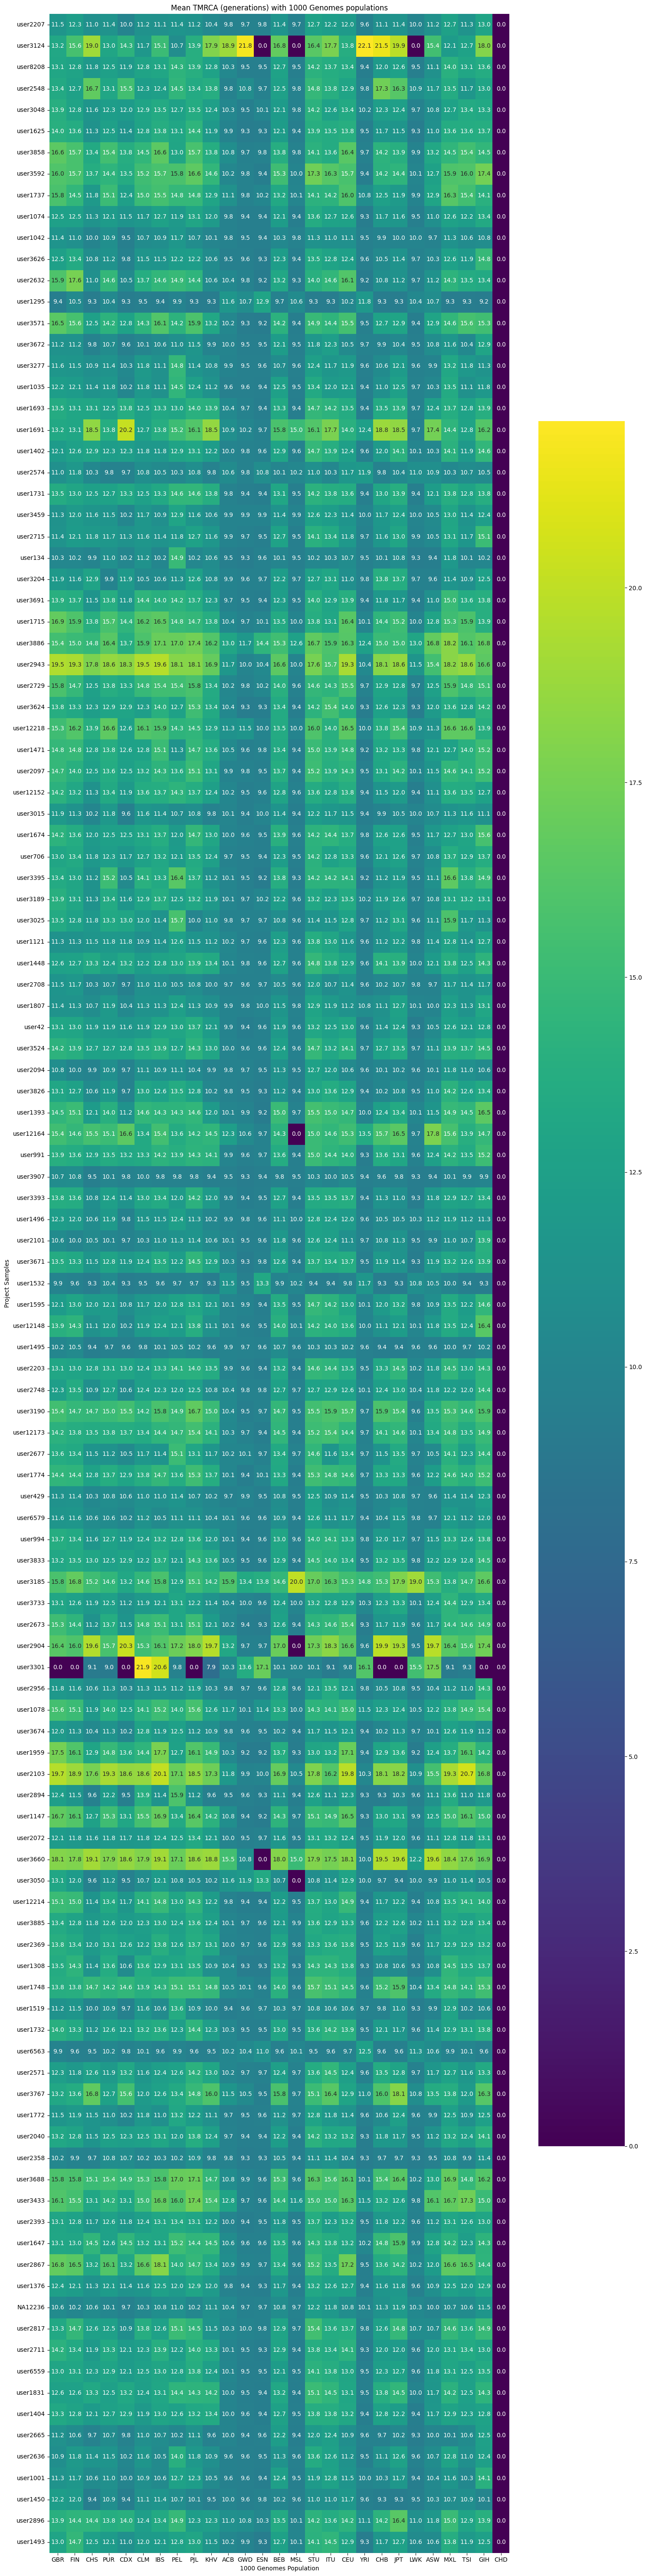

In [ ]:
def create_sharing_heatmap(project_samples, sample_df):
    """Create a heatmap of IBD sharing and TMRCA between project samples and populations"""
    # Initialize results matrices with float dtype
    populations = sample_df['Population'].unique()
    sharing_matrix = pd.DataFrame(0.0, index=project_samples, columns=populations, dtype=float)
    tmrca_gen_matrix = pd.DataFrame(0.0, index=project_samples, columns=populations, dtype=float)
    tmrca_years_matrix = pd.DataFrame(0.0, index=project_samples, columns=populations, dtype=float)
    
    # Calculate sharing for each sample-population pair
    for sample in project_samples:
        pop_stats = calculate_sharing_stats(sample, sample_df)
        for _, row in pop_stats.iterrows():
            if pd.notna(row['Population']):
                sharing_matrix.loc[sample, row['Population']] = float(row['total_length_cM'])
                tmrca_gen_matrix.loc[sample, row['Population']] = float(row['mean_tmrca_gen'])
                tmrca_years_matrix.loc[sample, row['Population']] = float(row['mean_tmrca_years'])
    
    # Create single plot for TMRCA generations
    plt.figure(figsize=(15, len(project_samples) * 0.5))
    sns.heatmap(tmrca_gen_matrix, cmap='viridis', annot=True, fmt='.1f')
    plt.title('Mean TMRCA (generations) with 1000 Genomes populations')
    plt.xlabel('1000 Genomes Population')
    plt.ylabel('Project Samples')
    plt.tight_layout()
    plt.show()
    
    return sharing_matrix, tmrca_gen_matrix, tmrca_years_matrix

# Save all three matrices
sharing_matrix, tmrca_gen_matrix, tmrca_years_matrix = create_sharing_heatmap(project_samples, sample_df)

# Save the matrices
sharing_matrix.to_csv(os.path.join(results_directory, 'sharing_matrix.csv'))
tmrca_gen_matrix.to_csv(os.path.join(results_directory, 'tmrca_generations_matrix.csv'))
tmrca_years_matrix.to_csv(os.path.join(results_directory, 'tmrca_years_matrix.csv'))

/tmp/ipykernel_702620/2866388066.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
/tmp/ipykernel_702620/2866388066.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)


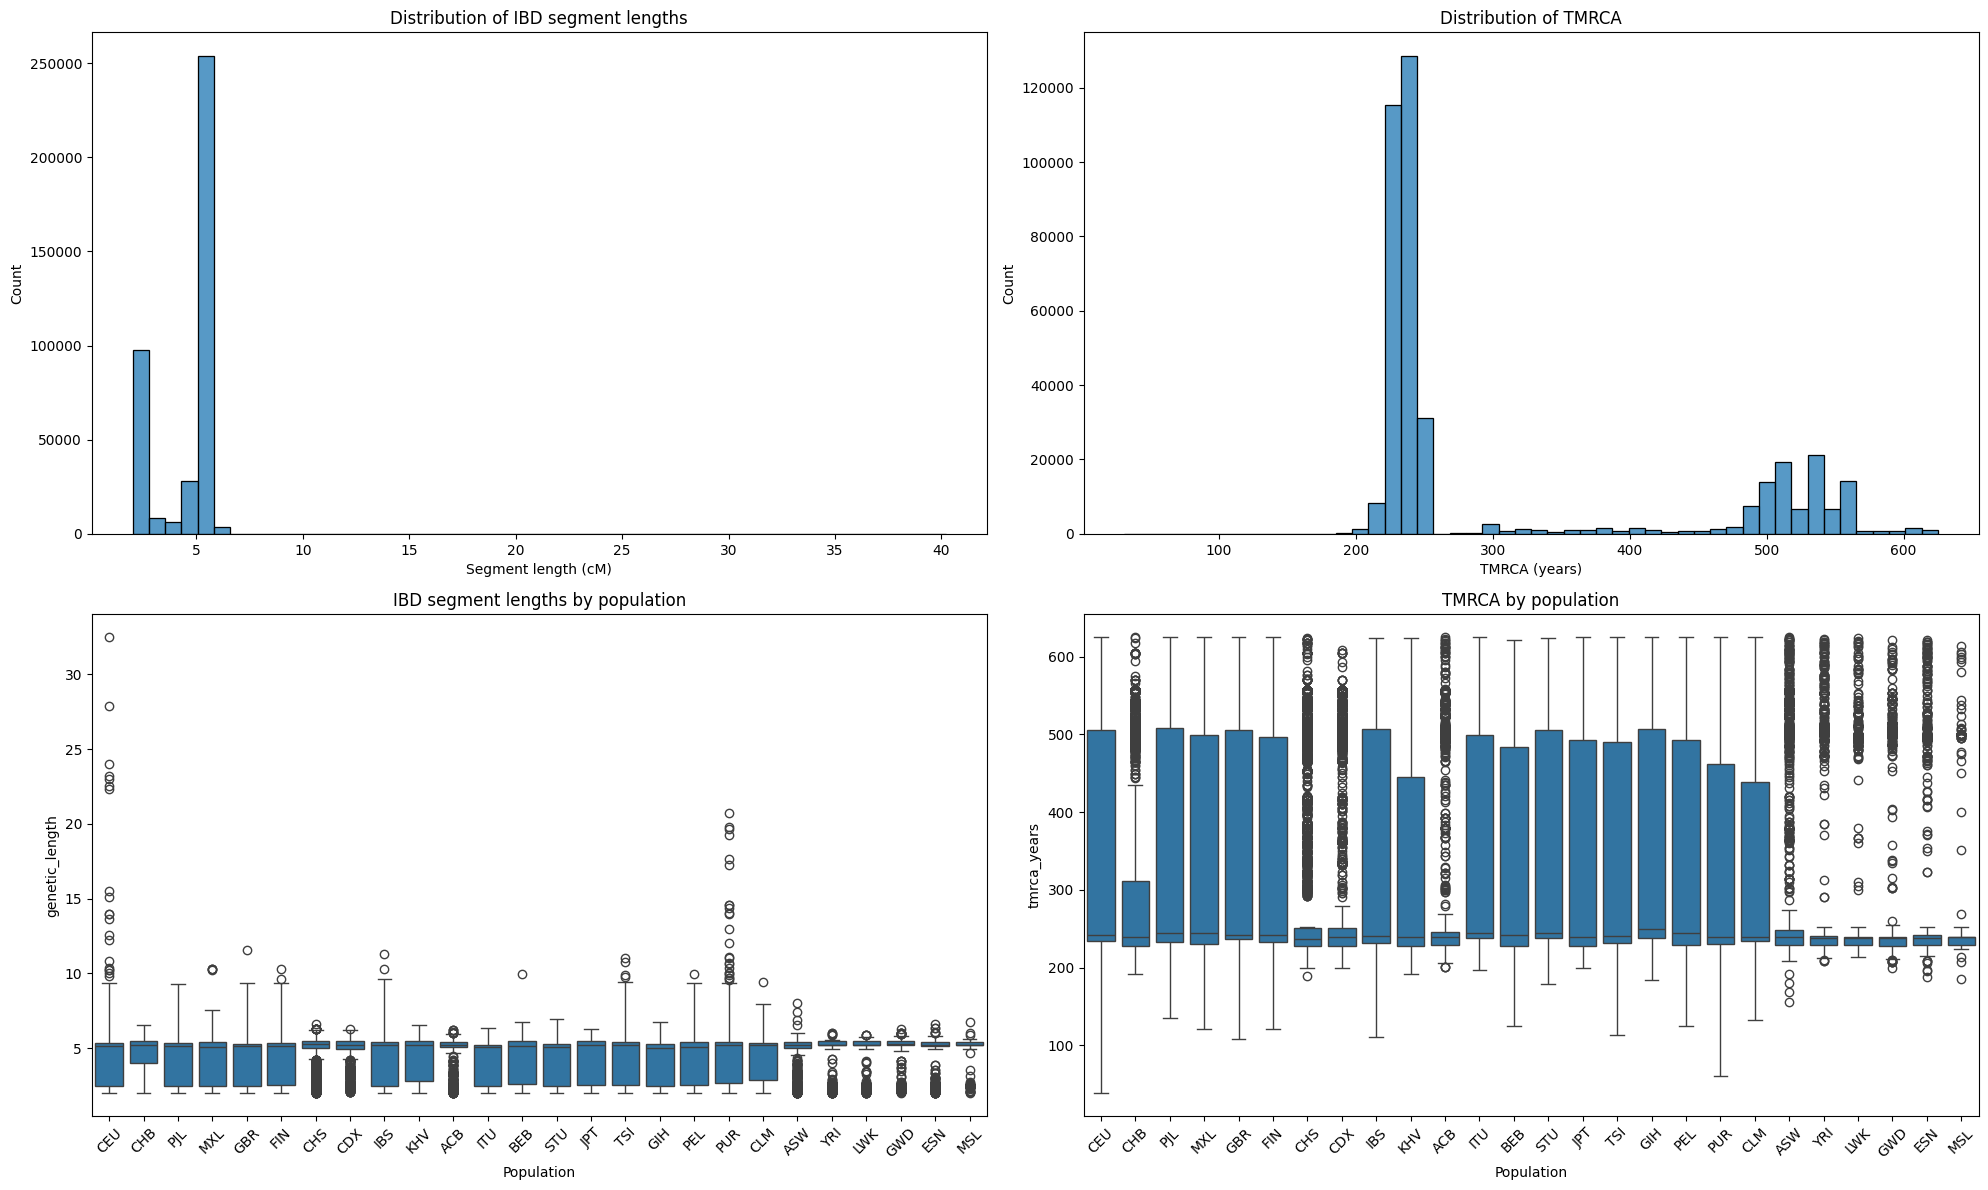

In [ ]:
def analyze_segment_distribution(project_samples, sample_df):
    """Analyze the distribution of IBD segment lengths and TMRCA"""
    # Create figure with multiple subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
    # Get project segments
    project_segments = segments[
        (segments['id1'].isin(project_samples)) | 
        (segments['id2'].isin(project_samples))
    ].copy()
    
    # Calculate TMRCA for segments
    project_segments['tmrca_generations'] = project_segments['genetic_length'].apply(lambda x: 50/x)
    project_segments['tmrca_years'] = project_segments['tmrca_generations'] * 25
    
    # Add population information
    project_segments['other_id'] = np.where(
        project_segments['id1'].isin(project_samples),
        project_segments['id2'],
        project_segments['id1']
    )
    
    merged_segments = pd.merge(
        project_segments,
        sample_df[['Sample', 'Population', 'Population Description']],
        left_on='other_id',
        right_on='Sample',
        how='left'
    )
    
    # Plot 1: Segment length distribution
    sns.histplot(data=merged_segments, x='genetic_length', bins=50, ax=ax1)
    ax1.set_title('Distribution of IBD segment lengths')
    ax1.set_xlabel('Segment length (cM)')
    
    # Plot 2: TMRCA distribution
    sns.histplot(data=merged_segments, x='tmrca_years', bins=50, ax=ax2)
    ax2.set_title('Distribution of TMRCA')
    ax2.set_xlabel('TMRCA (years)')
    
    # Plot 3: Box plot of segment lengths by population
    sns.boxplot(data=merged_segments, x='Population', y='genetic_length', ax=ax3)
    ax3.set_title('IBD segment lengths by population')
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
    
    # Plot 4: Box plot of TMRCA by population
    sns.boxplot(data=merged_segments, x='Population', y='tmrca_years', ax=ax4)
    ax4.set_title('TMRCA by population')
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    return fig, merged_segments

distribution_fig, merged_segments = analyze_segment_distribution(project_samples, sample_df)

In [32]:
def summarize_population_sharing(project_samples, sample_df):
    """Create a summary of IBD sharing and TMRCA with each population"""
    all_stats = []
    
    for sample in project_samples:
        pop_stats = calculate_sharing_stats(sample, sample_df)
        all_stats.append(pop_stats)
    
    # Combine all statistics
    summary_df = pd.concat(all_stats, ignore_index=True)
    
    # Create pivot table for easy viewing
    summary_pivot = pd.pivot_table(
        summary_df, 
        values=['total_length_cM', 'n_segments', 'mean_tmrca_years', 'min_tmrca_years', 'max_tmrca_years'],
        index='sample_id',
        columns='Population',
        aggfunc='first'
    )
    
    return summary_df, summary_pivot

summary_df, summary_pivot = summarize_population_sharing(project_samples, sample_df)

print("Summary of sharing statistics:")
print(summary_df.head())

print("\nPivot table view:")
print(summary_pivot.head())

# Save the files
summary_df.to_csv(os.path.join(results_directory, 'detailed_summary.csv'))
summary_pivot.to_csv(os.path.join(results_directory, 'pivot_summary.csv'))
distribution_fig.savefig(os.path.join(results_directory, 'segment_distribution.png'), 
                        bbox_inches='tight', 
                        dpi=300)

Summary of sharing statistics:
  sample_id Population                             Population Description  \
0  user1693        ACB                      African Caribbean in Barbados   
1  user1693        ASW                   African Ancestry in Southwest US   
2  user1693        BEB                              Bengali in Bangladesh   
3  user1693        CDX                Chinese Dai in Xishuangbanna, China   
4  user1693        CEU  Utah residents with Northern and Western Europ...   

   n_segments  total_length_cM  mean_length_cM  std_length_cM  mean_tmrca_gen  \
0          80           403.07            5.04           0.79           10.40   
1          42           193.53            4.61           1.35           12.38   
2         134           577.72            4.31           1.39           13.34   
3          89           380.06            4.27           1.49           13.77   
4         473          2018.12            4.27           1.40           13.54   

   min_tmrca_gen  m

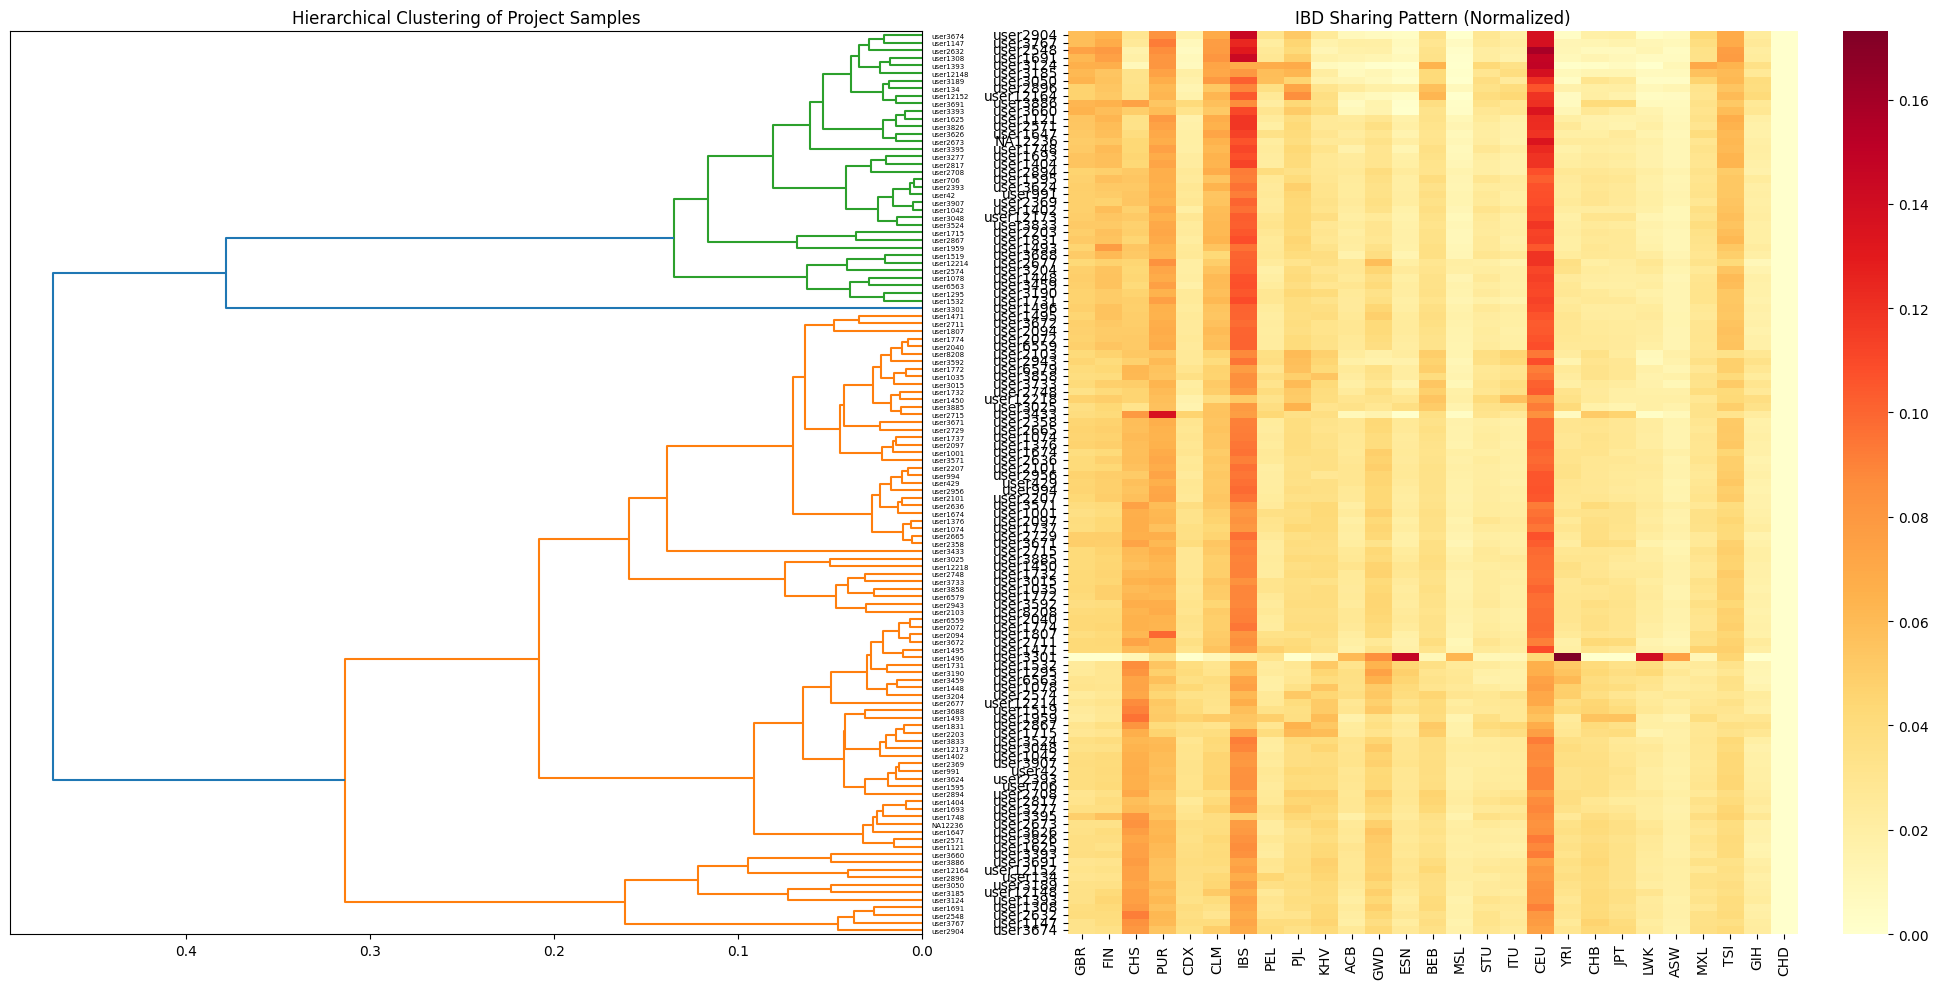

In [33]:
def perform_ibd_clustering(sharing_matrix, sample_df):
    """
    Perform hierarchical clustering on IBD sharing patterns and create visualization
    """
    from scipy.cluster import hierarchy
    from scipy.spatial.distance import pdist
    
    # Normalize the sharing matrix
    normalized_sharing = sharing_matrix.div(sharing_matrix.sum(axis=1), axis=0)
    
    # Calculate distance matrix and perform clustering
    dist_matrix = pdist(normalized_sharing, metric='euclidean')
    linkage_matrix = hierarchy.linkage(dist_matrix, method='ward')
    
    # Create figure with dendrogram and heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plot dendrogram
    dendrogram = hierarchy.dendrogram(
        linkage_matrix,
        labels=sharing_matrix.index,
        orientation='left',
        ax=ax1
    )
    ax1.set_title('Hierarchical Clustering of Project Samples')
    
    # Get the ordering of samples from dendrogram
    ordered_samples = [sharing_matrix.index[i] for i in dendrogram['leaves']]
    
    # Plot heatmap with samples ordered by clustering
    sns.heatmap(
        normalized_sharing.loc[ordered_samples],
        cmap='YlOrRd',
        ax=ax2,
        xticklabels=True,
        yticklabels=True
    )
    ax2.set_title('IBD Sharing Pattern (Normalized)')
    plt.tight_layout()

perform_ibd_clustering(sharing_matrix, sample_df)

Number of clusters found: 1


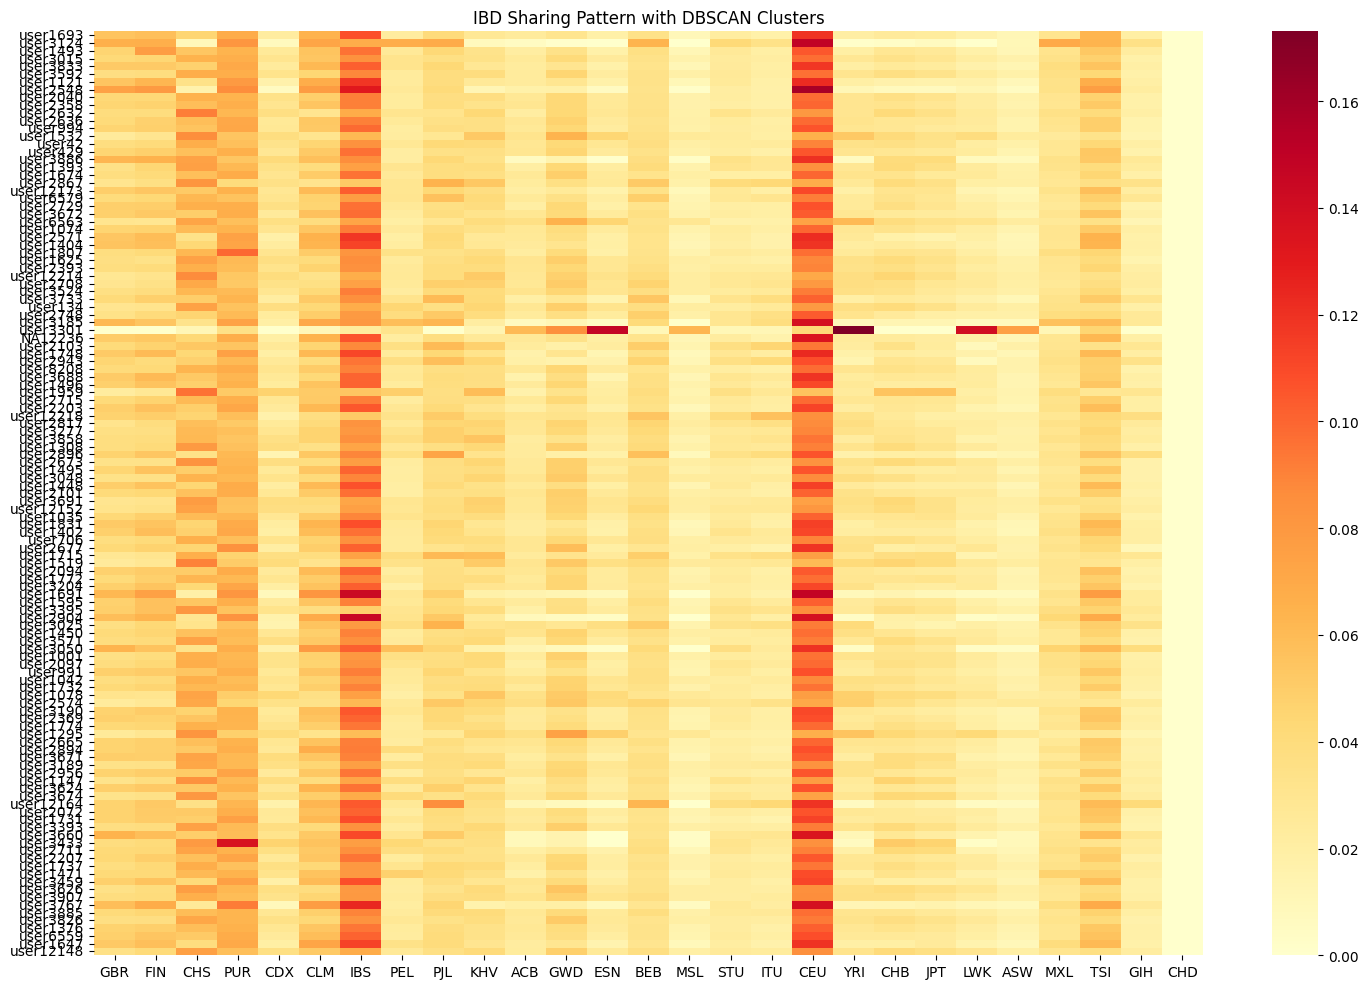

In [34]:
def perform_simple_dbscan(sharing_matrix, results_directory):
    """
    Perform basic DBSCAN clustering on IBD sharing patterns
    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import DBSCAN
    import os
    
    # Normalize the data
    normalized_sharing = sharing_matrix.div(sharing_matrix.sum(axis=1), axis=0)
    
    # Scale the data
    X = StandardScaler().fit_transform(normalized_sharing)
    
    # Perform DBSCAN clustering
    db = DBSCAN(eps=0.3, min_samples=3).fit(X)
    labels = db.labels_
    
    # Create cluster labels DataFrame
    cluster_assignments = pd.DataFrame({
        'Sample': sharing_matrix.index,
        'Cluster': [f'Cluster {i}' if i != -1 else 'Noise' for i in labels]
    })
    
    # Create simple plot
    plt.figure(figsize=(15, 10))
    sns.heatmap(
        normalized_sharing,
        cmap='YlOrRd',
        xticklabels=True,
        yticklabels=True
    )
    plt.title('IBD Sharing Pattern with DBSCAN Clusters')
    plt.tight_layout()
    
    # Save results
    cluster_assignments.to_csv(os.path.join(results_directory, 'dbscan_clusters.csv'), index=False)
    plt.savefig(os.path.join(results_directory, 'dbscan_heatmap.png'), bbox_inches='tight', dpi=300)
    
    return cluster_assignments

# Run the analysis
clusters = perform_simple_dbscan(sharing_matrix, results_directory)
print("Number of clusters found:", len(clusters['Cluster'].unique()))

# Save the original matrices
sharing_matrix.to_csv(os.path.join(results_directory, 'sharing_matrix.csv'))
tmrca_gen_matrix.to_csv(os.path.join(results_directory, 'tmrca_generations_matrix.csv'))
tmrca_years_matrix.to_csv(os.path.join(results_directory, 'tmrca_years_matrix.csv'))


Results for user1693:
   Population  Total_IBD_cM  Percent_Genome_IBD
4         CEU      2018.124               59.36
13        IBS      1822.750               53.61
22        PUR      1163.294               34.21
7         CLM      1094.669               32.20
24        TSI      1062.351               31.25
9         FIN       973.242               28.62
10        GBR       929.743               27.35
6         CHS       764.372               22.48
21        PJL       693.497               20.40
2         BEB       577.722               16.99
19        MXL       524.189               15.42
12        GWD       515.340               15.16
16        KHV       461.545               13.57
5         CHB       414.237               12.18
0         ACB       403.066               11.85
15        JPT       396.568               11.66
3         CDX       380.065               11.18
20        PEL       379.127               11.15
23        STU       375.400               11.04
25        YRI    

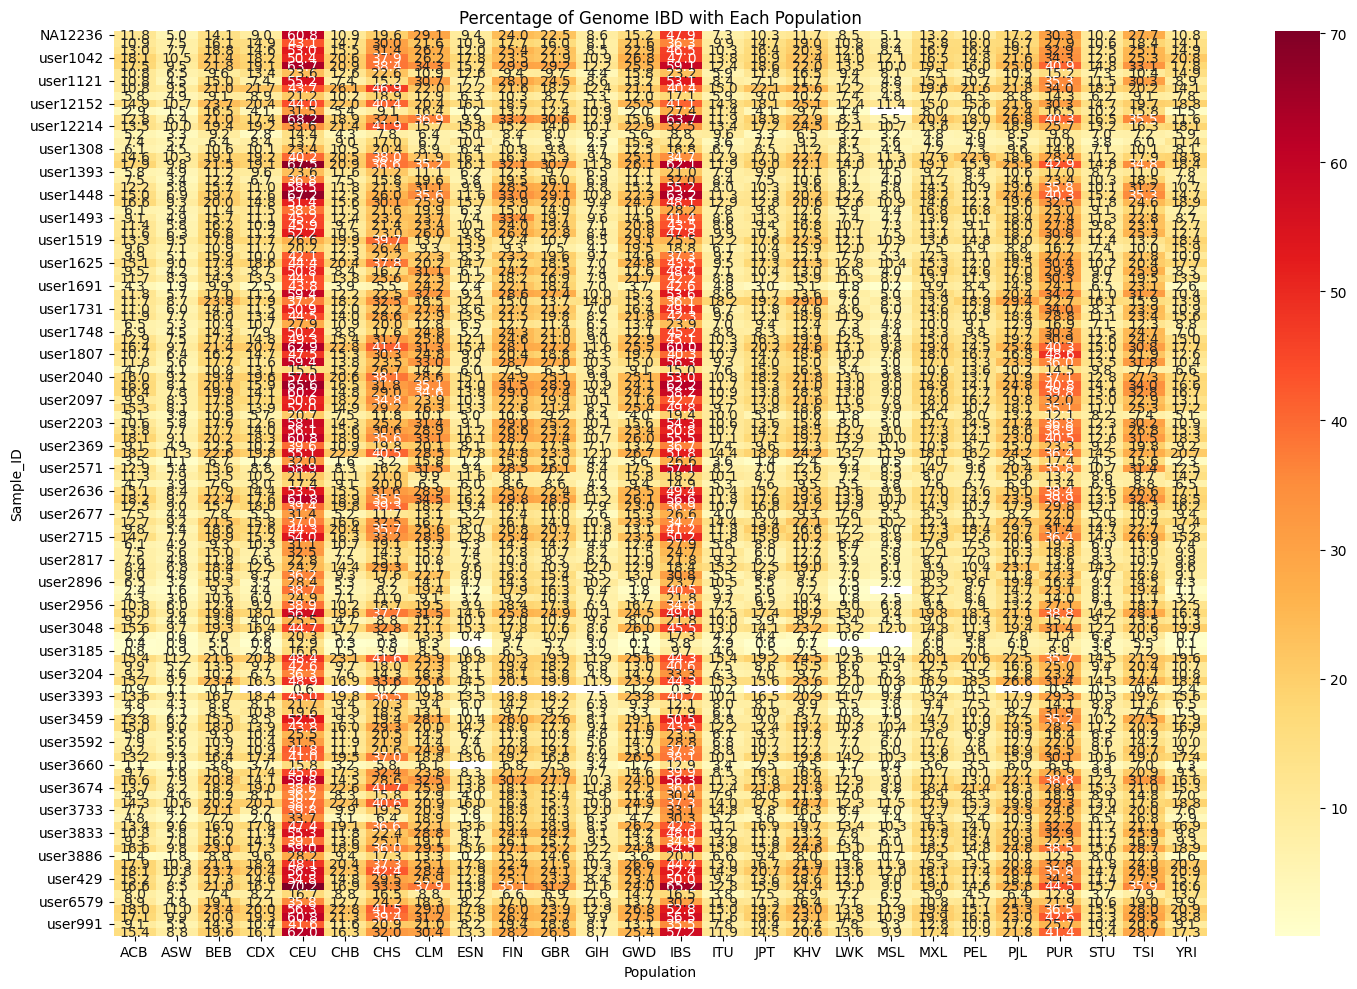

In [35]:
def calculate_ibd_percentages(sample_id, sample_df, total_genome_length=3400):
    """
    Calculate percentage of genome that is IBD with each population and super population
    
    Parameters:
    sample_id: ID of the project sample
    sample_df: 1000 Genomes metadata DataFrame
    total_genome_length: Total genetic length of genome in cM (default 3400)
    """
    # Get IBD segments for this sample
    sample_segments = segments[(segments['id1'] == sample_id) | (segments['id2'] == sample_id)].copy()
    
    # Get other sample ID
    sample_segments['other_id'] = np.where(
        sample_segments['id1'] == sample_id,
        sample_segments['id2'],
        sample_segments['id1']
    )
    
    # Merge with population information
    sharing_df = pd.merge(
        sample_segments,
        sample_df[['Sample', 'Population', 'Population Description']],
        left_on='other_id',
        right_on='Sample',
        how='left'
    )
    
    # Calculate total IBD length by population
    pop_totals = sharing_df.groupby('Population')['genetic_length'].sum()
    pop_percentages = (pop_totals / total_genome_length * 100).round(2)
    
    # Create summary DataFrame
    summary = pd.DataFrame({
        'Population': pop_percentages.index,
        'Total_IBD_cM': pop_totals.values,
        'Percent_Genome_IBD': pop_percentages.values
    })
    
    return summary

# Calculate for all project samples
all_percentages = {}
for sample in project_samples:
    percentages = calculate_ibd_percentages(sample, sample_df)
    all_percentages[sample] = percentages
    
    print(f"\nResults for {sample}:")
    print(percentages.sort_values('Percent_Genome_IBD', ascending=False))

# Combine all results into one DataFrame
combined_results = pd.concat(
    {sample: df for sample, df in all_percentages.items()},
    names=['Sample_ID']
).reset_index()

# Save results
combined_results.to_csv(os.path.join(results_directory, 'ibd_percentages.csv'), index=False)

# Create visualization
plt.figure(figsize=(15, 10))
sns.heatmap(
    combined_results.pivot(index='Sample_ID', columns='Population', values='Percent_Genome_IBD'),
    cmap='YlOrRd',
    annot=True,
    fmt='.1f'
)
plt.title('Percentage of Genome IBD with Each Population')
plt.tight_layout()
plt.show()


Results for user1693:
                Population  Total_IBD_cM  Percent_Genome_IBD
Total_African  All African      2226.100               65.47
3                      GWD       515.340               15.16
0                      ACB       403.066               11.85
6                      YRI       352.218               10.36
2                      ESN       314.212                9.24
4                      LWK       277.725                8.17
1                      ASW       193.528                5.69
5                      MSL       170.011                5.00

Results for user3124:
                Population  Total_IBD_cM  Percent_Genome_IBD
Total_African  All African        52.053                1.53
1                      ASW        30.755                0.90
0                      ACB        14.493                0.43
3                      YRI         4.516                0.13
2                      GWD         2.289                0.07

Results for user1493:
                

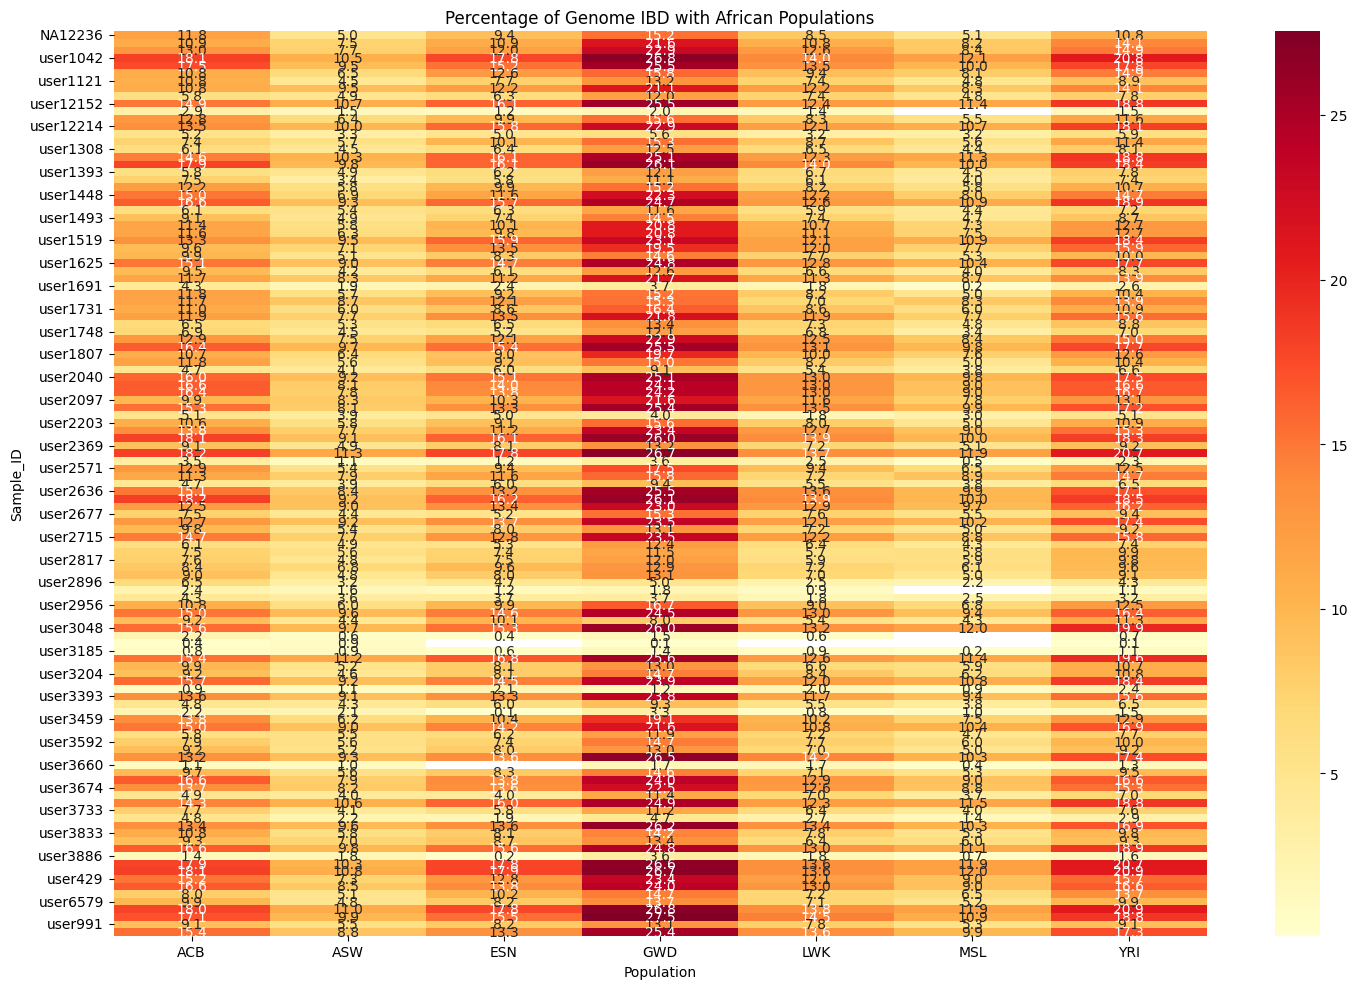

In [39]:
def calculate_african_ibd_percentages(sample_id, sample_df, total_genome_length=3400):
    """
    Calculate percentage of genome that is IBD with African populations
    """
    # Define African populations
    african_pops = ['ESN', 'GWD', 'YRI', 'LWK', 'MSL', 'ACB', 'ASW']  # Add any others I might have missed
    
    # Get IBD segments for this sample
    sample_segments = segments[(segments['id1'] == sample_id) | (segments['id2'] == sample_id)].copy()
    
    # Get other sample ID
    sample_segments['other_id'] = np.where(
        sample_segments['id1'] == sample_id,
        sample_segments['id2'],
        sample_segments['id1']
    )
    
    # Merge with population information
    sharing_df = pd.merge(
        sample_segments,
        sample_df[['Sample', 'Population', 'Population Description']],
        left_on='other_id',
        right_on='Sample',
        how='left'
    )
    
    # Filter for African populations
    african_sharing = sharing_df[sharing_df['Population'].isin(african_pops)]
    
    # Calculate total IBD length by population
    pop_totals = african_sharing.groupby('Population')['genetic_length'].sum()
    pop_percentages = (pop_totals / total_genome_length * 100).round(2)
    
    # Calculate total African IBD
    total_african = pop_totals.sum()
    total_african_percentage = (total_african / total_genome_length * 100).round(2)
    
    # Create summary DataFrame
    summary = pd.DataFrame({
        'Population': pop_percentages.index,
        'Total_IBD_cM': pop_totals.values,
        'Percent_Genome_IBD': pop_percentages.values
    })
    
    # Add total row
    summary.loc['Total_African'] = ['All African', total_african, total_african_percentage]
    
    return summary

# Calculate for all project samples
all_percentages = {}
for sample in project_samples:
    percentages = calculate_african_ibd_percentages(sample, sample_df)
    all_percentages[sample] = percentages
    
    print(f"\nResults for {sample}:")
    print(percentages.sort_values('Percent_Genome_IBD', ascending=False))

# Combine all results
combined_results = pd.concat(
    {sample: df for sample, df in all_percentages.items()},
    names=['Sample_ID']
).reset_index()

# Save results
combined_results.to_csv(os.path.join(results_directory, 'african_ibd_percentages.csv'), index=False)

# Create visualization
plt.figure(figsize=(15, 10))
sns.heatmap(
    combined_results[combined_results['Population'] != 'All African'].pivot(
        index='Sample_ID', 
        columns='Population', 
        values='Percent_Genome_IBD'
    ),
    cmap='YlOrRd',
    annot=True,
    fmt='.1f'
)
plt.title('Percentage of Genome IBD with African Populations')
plt.tight_layout()
plt.show()

## New Approach

In [ ]:
def calculate_time_stratified_ancestry(sample_id, sample_df, ibd_segments, reference_populations, total_genome_length=3400):
    """
    Calculate ancestry components across different time periods based on IBD segment length.
    
    Args:
        sample_id: ID of the sample to analyze
        sample_df: DataFrame with reference population metadata
        ibd_segments: DataFrame of IBD segments
        reference_populations: List of reference populations to analyze
        total_genome_length: Total genetic length of genome in cM (default 3400)
        
    Returns:
        ancestry_by_time: DataFrame with ancestry proportions by population and time period
    """
    # Get IBD segments for this sample
    sample_segs = ibd_segments[(ibd_segments['id1'] == sample_id) | (ibd_segments['id2'] == sample_id)].copy()
    
    # Extract other sample ID
    sample_segs['other_id'] = np.where(
        sample_segs['id1'] == sample_id,
        sample_segs['id2'],
        sample_segs['id1']
    )
    
    # Merge with population information
    sharing_df = pd.merge(
        sample_segs,
        sample_df[['Sample', 'Population', 'Population Description']],
        left_on='other_id',
        right_on='Sample',
        how='left'
    )
    
    # Define time periods - more granular, especially for recent periods
    time_periods = [
        (0, 50, 'Very Recent (0-50 years)'),
        (51, 100, 'Recent (51-100 years)'),
        (101, 150, 'Recent Historical (101-150 years)'),
        (151, 200, 'Historical (151-200 years)'),
        (201, 300, 'Early Modern (201-300 years)'),
        (301, 500, 'Colonial Era (301-500 years)'),
        (501, 1000, 'Medieval (501-1000 years)'),
        (1001, 2000, 'Ancient (1001-2000 years)'),
        (2001, float('inf'), 'Prehistoric (>2000 years)')
    ]
    
    # Calculate TMRCA (years) based on genetic length
    # Using the 50/genetic_length formula for TMRCA in generations
    # Then multiply by 25 years per generation
    sharing_df['tmrca_years'] = 25 * 50 / sharing_df['genetic_length']
    
    # Assign time periods to each segment
    def assign_time_period(years):
        for start, end, label in time_periods:
            if start <= years < end:
                return label
        return 'Unknown'
        
    sharing_df['time_period'] = sharing_df['tmrca_years'].apply(assign_time_period)
    
    # Initialize results structure - for each population and time period
    ancestry_data = {}
    for pop in reference_populations:
        ancestry_data[pop] = {period[2]: 0 for period in time_periods}
    
    # Sum IBD sharing by population and time period
    for pop in reference_populations:
        pop_data = sharing_df[sharing_df['Population'] == pop]
        for period_start, period_end, period_name in time_periods:
            period_data = pop_data[(pop_data['tmrca_years'] >= period_start) & 
                                  (pop_data['tmrca_years'] < period_end)]
            total_cm = period_data['genetic_length'].sum()
            ancestry_data[pop][period_name] = total_cm
    
    # Convert to dataframe
    ancestry_df = pd.DataFrame(ancestry_data)
    
    # Calculate percentages of genome (normalize by total genome length)
    ancestry_pct = ancestry_df / total_genome_length * 100
    
    # Add total row
    ancestry_pct.loc['Total'] = ancestry_pct.sum()
    
    # Add weighted time-based ancestry composition
    # Higher weight for more recent ancestry
    weights = {
        'Very Recent (0-50 years)': 1.0,
        'Recent (51-100 years)': 0.9,
        'Recent Historical (101-150 years)': 0.8,
        'Historical (151-200 years)': 0.7,
        'Early Modern (201-300 years)': 0.6,
        'Colonial Era (301-500 years)': 0.5,
        'Medieval (501-1000 years)': 0.4,
        'Ancient (1001-2000 years)': 0.3,
        'Prehistoric (>2000 years)': 0.2
    }
    
    # Calculate weighted ancestry
    weighted_ancestry = pd.Series(0.0, index=reference_populations)
    for period in weights:
        if period in ancestry_pct.index:
            weighted_ancestry += ancestry_pct.loc[period] * weights[period]
    
    # Normalize to sum to 100%
    if weighted_ancestry.sum() > 0:
        weighted_ancestry = weighted_ancestry / weighted_ancestry.sum() * 100
    
    ancestry_pct.loc['Weighted Total'] = weighted_ancestry
    
    return ancestry_pct

In [ ]:
def create_consensus_ancestry_map(sample_id, sample_df, ibd_segments, chromosome_lengths, window_size=1000000):
    """
    Create a position-specific ancestry map based on overlapping IBD segments.
    
    Args:
        sample_id: ID of the sample to analyze
        sample_df: DataFrame with reference population metadata
        ibd_segments: DataFrame of IBD segments
        chromosome_lengths: Dictionary of chromosome lengths {chrom: length}
        window_size: Size of genomic windows in bp
        
    Returns:
        ancestry_map: Dictionary {chrom: {position: {population: probability}}}
    """
    # Get IBD segments for this sample
    sample_segs = ibd_segments[(ibd_segments['id1'] == sample_id) | (ibd_segments['id2'] == sample_id)].copy()
    
    # Extract other sample ID and merge with population information
    sample_segs['other_id'] = np.where(
        sample_segs['id1'] == sample_id,
        sample_segs['id2'],
        sample_segs['id1']
    )
    
    sharing_df = pd.merge(
        sample_segs,
        sample_df[['Sample', 'Population']],
        left_on='other_id',
        right_on='Sample',
        how='left'
    )
    
    # Calculate TMRCA in years for weighting
    sharing_df['tmrca_years'] = 25 * 50 / sharing_df['genetic_length']
    
    # Weight based on segment length and recency (shorter TMRCA = higher weight)
    sharing_df['weight'] = sharing_df['genetic_length'] * (1000 / (sharing_df['tmrca_years'] + 100))
    
    # Get unique populations and chromosomes
    populations = sample_df['Population'].unique()
    chromosomes = sharing_df['chrom'].unique()
    
    # Initialize ancestry map
    ancestry_map = {}
    
    # Process each chromosome
    for chrom in chromosomes:
        chrom_segs = sharing_df[sharing_df['chrom'] == chrom]
        
        if chrom not in chromosome_lengths:
            continue
            
        # Create windows for this chromosome
        max_pos = chromosome_lengths[chrom]
        windows = range(0, max_pos + window_size, window_size)
        
        # Initialize ancestry probabilities for this chromosome
        chrom_ancestry = {window: {pop: 0.0 for pop in populations} for window in windows}
        
        # Process each segment to contribute to window probabilities
        for _, segment in chrom_segs.iterrows():
            start_window = (segment['phys_start'] // window_size) * window_size
            end_window = (segment['phys_end'] // window_size) * window_size
            
            # Apply segment contribution to each overlapping window
            for window in range(int(start_window), int(end_window) + window_size, window_size):
                if window in chrom_ancestry:
                    pop = segment['Population']
                    if pd.notna(pop):  # Skip if population is unknown
                        chrom_ancestry[window][pop] += segment['weight']
        
        # Normalize probabilities in each window
        for window in chrom_ancestry:
            total = sum(chrom_ancestry[window].values())
            if total > 0:
                for pop in chrom_ancestry[window]:
                    chrom_ancestry[window][pop] /= total
        
        ancestry_map[chrom] = chrom_ancestry
    
    return ancestry_map

In [ ]:
def compare_with_rfmix(ibd_ancestry_map, rfmix_file, sample_id, window_size=1000000):
    """
    Compare IBD-based ancestry inference with RFMix results.
    
    Args:
        ibd_ancestry_map: Ancestry map from IBD-based method
        rfmix_file: Path to RFMix output file
        sample_id: ID of the sample to analyze
        window_size: Size of genomic windows in bp (should match IBD map)
        
    Returns:
        comparison_df: DataFrame with comparison metrics
    """
    # Load RFMix results
    rfmix_df = pd.read_csv(rfmix_file, sep='\t')
    
    # Filter for the sample of interest
    rfmix_sample = rfmix_df[rfmix_df['sample'] == sample_id]
    
    # Initialize comparison results
    comparison = {
        'chrom': [],
        'position': [],
        'rfmix_ancestry': [],
        'ibd_ancestry': [],
        'agreement': [],
        'ibd_confidence': []
    }
    
    # For each chromosome in both datasets
    for chrom in ibd_ancestry_map:
        if chrom not in rfmix_sample['chrom'].unique():
            continue
            
        rfmix_chrom = rfmix_sample[rfmix_sample['chrom'] == chrom]
        
        # Iterate through IBD ancestry windows
        for window, pop_probs in ibd_ancestry_map[chrom].items():
            # Find corresponding RFMix windows
            rfmix_windows = rfmix_chrom[
                (rfmix_chrom['start'] >= window) & 
                (rfmix_chrom['start'] < window + window_size)
            ]
            
            if rfmix_windows.empty:
                continue
                
            # Get most likely ancestry from IBD method
            ibd_ancestry = max(pop_probs.items(), key=lambda x: x[1])
            ibd_pop = ibd_ancestry[0]
            ibd_confidence = ibd_ancestry[1]
            
            # Get most common RFMix ancestry in this window
            rfmix_counts = rfmix_windows['ancestry'].value_counts()
            if not rfmix_counts.empty:
                rfmix_pop = rfmix_counts.index[0]
                
                # Check if they agree
                agreement = 1 if rfmix_pop == ibd_pop else 0
                
                # Store comparison
                comparison['chrom'].append(chrom)
                comparison['position'].append(window)
                comparison['rfmix_ancestry'].append(rfmix_pop)
                comparison['ibd_ancestry'].append(ibd_pop)
                comparison['agreement'].append(agreement)
                comparison['ibd_confidence'].append(ibd_confidence)
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(comparison)
    
    # Calculate overall agreement
    overall_agreement = comparison_df['agreement'].mean() if not comparison_df.empty else 0
    print(f"Overall agreement with RFMix: {overall_agreement:.2%}")
    
    return comparison_df

In [ ]:
def run_ancestry_analysis(seg_file, fam_file, dict_file=None, rfmix_file=None, output_dir="ancestry_results"):
    """
    Run complete IBD-based ancestry analysis with time stratification and consensus mapping.
    
    Args:
        seg_file: Path to IBD segment file
        fam_file: Path to sample metadata file
        dict_file: Path to ID mapping file (optional)
        rfmix_file: Path to RFMix results for comparison (optional)
        output_dir: Directory to save results
        
    Returns:
        results: Dictionary with analysis results
    """
    os.makedirs(output_dir, exist_ok=True)
    
    print("1. Loading genetic data...")
    seg_df, individuals, individual_to_bonsai = load_genetic_data(seg_file, fam_file, dict_file)
    
    if seg_df is None:
        print("Error loading data. Exiting.")
        return None
    
    # Extract list of reference populations
    reference_pops = sorted(set(
        pop for _, info in individuals.items() 
        if 'population' in info
        for pop in [info['population']]
        if pop
    ))
    
    print(f"Found {len(reference_pops)} reference populations")
    
    # Load chromosome lengths (example - should be customized for your genome build)
    chromosome_lengths = {
        str(i): 250000000 for i in range(1, 23)  # Default length as placeholder
    }
    
    # Define samples to analyze (either all or a subset)
    project_samples = [
        id for id in individual_to_bonsai.keys()
        if id not in sample_df['Sample'].values
    ]
    
    print(f"Analyzing {len(project_samples)} project samples")
    
    # Initialize results
    results = {
        'time_stratified': {},
        'consensus_maps': {},
        'rfmix_comparison': {}
    }
    
    # Process each sample
    for i, sample_id in enumerate(project_samples):
        print(f"Processing sample {i+1}/{len(project_samples)}: {sample_id}")
        
        # Time-stratified ancestry analysis
        ancestry_by_time = calculate_time_stratified_ancestry(
            sample_id, sample_df, seg_df, reference_pops
        )
        results['time_stratified'][sample_id] = ancestry_by_time
        
        # Save time-stratified results
        ancestry_by_time.to_csv(
            os.path.join(output_dir, f"{sample_id}_time_stratified_ancestry.csv")
        )
        
        # Create ancestry map
        ancestry_map = create_consensus_ancestry_map(
            sample_id, sample_df, seg_df, chromosome_lengths
        )
        results['consensus_maps'][sample_id] = ancestry_map
        
        # Save map to file (as JSON)
        with open(os.path.join(output_dir, f"{sample_id}_ancestry_map.json"), 'w') as f:
            # Convert ancestry map to serializable format
            serializable_map = {}
            for chrom, chrom_data in ancestry_map.items():
                serializable_map[chrom] = {
                    str(pos): {pop: prob for pop, prob in pos_data.items()}
                    for pos, pos_data in chrom_data.items()
                }
            json.dump(serializable_map, f, indent=2)
        
        # Compare with RFMix if available
        if rfmix_file:
            comparison = compare_with_rfmix(
                ancestry_map, rfmix_file, sample_id
            )
            results['rfmix_comparison'][sample_id] = comparison
            
            comparison.to_csv(
                os.path.join(output_dir, f"{sample_id}_rfmix_comparison.csv")
            )
    
    # Create summary figures
    print("Creating summary visualizations...")
    
    # 1. Time-stratified ancestry composition
    for sample_id, ancestry_data in results['time_stratified'].items():
        plt.figure(figsize=(15, 10))
        sns.heatmap(ancestry_data.iloc[:-2], annot=True, cmap='YlOrRd', fmt='.1f')
        plt.title(f"Time-Stratified Ancestry for {sample_id}")
        plt.ylabel("Time Period")
        plt.xlabel("Reference Population")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{sample_id}_time_heatmap.png"))
        plt.close()
        
        # Stacked bar chart of ancestry over time
        ancestry_data_t = ancestry_data.iloc[:-2].T
        ancestry_data_t = ancestry_data_t / ancestry_data_t.sum() * 100
        
        plt.figure(figsize=(15, 8))
        ancestry_data_t.plot(kind='bar', stacked=True, colormap='tab20')
        plt.title(f"Ancestry Composition Over Time for {sample_id}")
        plt.xlabel("Reference Population")
        plt.ylabel("Percentage of Ancestry")
        plt.legend(title="Time Period")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{sample_id}_time_stacked.png"))
        plt.close()
    
    # Create chromosome painting for each sample using consensus maps
    for sample_id, ancestry_map in results['consensus_maps'].items():
        chrom_paint_dir = os.path.join(output_dir, f"{sample_id}_chromosome_paintings")
        os.makedirs(chrom_paint_dir, exist_ok=True)
        
        for chrom, chrom_data in ancestry_map.items():
            positions = sorted(chrom_data.keys())
            populations = list(next(iter(chrom_data.values())).keys())
            
            # Create a position x population matrix
            data = np.zeros((len(positions), len(populations)))
            for i, pos in enumerate(positions):
                for j, pop in enumerate(populations):
                    data[i, j] = chrom_data[pos][pop]
            
            # Create a DataFrame for easier plotting
            df = pd.DataFrame(data, index=positions, columns=populations)
            
            # Plot chromosome painting
            plt.figure(figsize=(15, 5))
            plt.imshow(df.T, aspect='auto', interpolation='none', cmap='tab20')
            plt.colorbar(label='Probability')
            plt.title(f"Chromosome {chrom} Ancestry Painting for {sample_id}")
            plt.xlabel("Position (MB)")
            plt.ylabel("Population")
            plt.yticks(range(len(populations)), populations)
            plt.tight_layout()
            plt.savefig(os.path.join(chrom_paint_dir, f"chrom_{chrom}_painting.png"))
            plt.close()
    
    print("Analysis complete!")
    return results

In [1]:
!poetry run jupyter nbconvert --to pdf DRAFT_Lab10_IBD_1000_Genomes_DRAFT.ipynb

[NbConvertApp] Converting notebook DRAFT_Lab10_IBD_1000_Genomes_DRAFT.ipynb to pdf
[NbConvertApp] Support files will be in DRAFT_Lab10_IBD_1000_Genomes_DRAFT_files/
[NbConvertApp] Making directory ./DRAFT_Lab10_IBD_1000_Genomes_DRAFT_files
[NbConvertApp] Writing 412383 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 3520821 bytes to DRAFT_Lab10_IBD_1000_Genomes_DRAFT.pdf
